In [17]:
import glob, matplotlib, pandas, argparse, sys
import numpy as np
# The following package is used to scan through different values of k and find the optimal value using the gap
# and gap* statistic. More info here https://github.com/milesgranger/gap_statistic
# Will need to adapt this to send fits to different machines for different values of k
#sys.path.append("/users/whopkins/pMSSM_clustering/sigclustering/sigclustering/python/my_gap_statistic")
#from my_gap_statistic import OptimalK2
from gap_statistic import OptimalK
# Beautification of plot utilitiest
from sklearn.cluster import KMeans, MiniBatchKMeans
randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [18]:
#dataPath = '/users/whopkins/pMSSM_clustering/sigclustering/sigclustering/python/pMSSM_EW_nearContour.h5'
dataPath = '/data/atlasfs02/c/users/whopkins/pMSSM/EW_h5/*.h5'
dataFilePaths = glob.glob(dataPath)
batch_size = 50000

In [19]:
loadBranches = ['MET', 'pT_1jet', 'pT_2jet', 'nj_good', 'pT_1bjet', 'num_bjets', 'nLep_signal', 'pT_1lep',]
testData = pandas.read_hdf(dataFilePaths[0])
dfs = []
for path in dataFilePaths:
    dfs.append(pandas.read_hdf(path))
allData = pandas.concat(dfs)
#allData = pandas.read_hdf(dataPath, chunksize=batch_size, iterator=True)
#allData = pandas.read_hdf(dataPath)#, chunksize=batch_size, iterator=True)

# for chunk in testData:
#     print(chunk.keys())
#     #print(chunk)
#     print(chunk['pT_1jet'].min(), chunk['pT_1jet'].max())

print(testData['pT_1jet'].min(), testData['pT_1jet'].max())


-0.1 0.7908583879470825


In [20]:
# The idea was to remove models for which we expect less than the minimum number of events (e.g., 10 events)
# This will need to be revised now that we use iterators
lumi = 139
#lumi = 300
minEvents = 10
print(allData)
# highCrossIndex = allData['cross_section']*lumi > minEvents
# highCrossSigs = allData[highCrossIndex]
# print(highCrossIndex.sum())

      clustering   Event  eventWeight       MET   nj_good  num_bjets  \
7054         0.0  7055.0     0.000761  0.017634  0.157895        0.0   
442          0.0   443.0     0.000761  0.022645  0.105263        0.0   
3954         0.0  3955.0     0.000761  0.046691  0.052632        0.0   
2288         0.0  2289.0     0.000761  0.017526  0.052632        0.0   
3196         0.0  3197.0     0.000761  0.018854  0.052632        0.0   
...          ...     ...          ...       ...       ...        ...   
3046         0.0  3047.0     0.003547  0.137061  0.052632        0.0   
9917         0.0  9918.0     0.002731  0.204558  0.210526        0.1   
4079         0.0  4080.0     0.002122  0.141827  0.157895        0.0   
2254         0.0  2255.0     0.003436  0.135357  0.157895        0.1   
2915         0.0  2916.0     0.003100  0.258729  0.157895        0.2   

      nLep_signal  nLep_base   pT_1lep  eta_1lep  ...  pT_5jet  eta_5jet  \
7054     0.000000   0.000000 -0.100000 -0.100000  ...     -

In [34]:
# Needed to define my own clusterer to add the weights when using OptimalK. Not needed when using KMeans from scikit-learn directly.
def clusterer(data: np.ndarray, k: int, weights:np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    m = MiniBatchKMeans(n_clusters=k, random_state=random_state)
    #m = KMeans(n_clusters=k, random_state=random_state)
    m.fit(data, sample_weight=weights)
    #m.fit(X)
    #return m.cluster_centers_, m.predict(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(data)

doAvg = False
sumStr = ''
# if doAvg:
#     cDataWithName = reducedData
#     sumStr = '_avg'
trainBranches = loadBranches
varListStr = '_'.join(trainBranches)
#clusteringData = cDataWithName[trainBranches].copy(deep=True)
k_max=20

nJobs = 20
if k_max < 20:
    nJobs = k_max
optimalK = OptimalK(n_jobs=nJobs, clusterer=clusterer, clusterer_kwargs={"random_state":randomState,
                                                                     'weights':allData['cross_section'],
                                                                     })
n_clusters = optimalK(allData[trainBranches], cluster_array=np.arange(1, k_max+1))

ValueError: buffer source array is read-only

In [35]:
bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0 and diffI+1 > 1:
        bestK = diffI+1;
        break;
print(bestK)
# Find the optimal K
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig(f"plots/gap_{varListStr}{sumStr}.svg",bbox_inches='tight')
plt.savefig(f"plots/gap_{varListStr}{sumStr}.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap$_{k}$-(gap$_{k+1}$+$\sigma$(gap$_{k+1}$))')
plt.xlabel('k')
ax.text(0.65, 0.2, f'Optimal $k$ ={bestK}', transform=ax.transAxes)#, fontsize=font)
plt.savefig(f"plots/diff_{varListStr}{sumStr}.svg",bbox_inches='tight')
plt.savefig(f"plots/diff_{varListStr}{sumStr}.pdf",bbox_inches='tight')

TypeError: 'NoneType' object is not subscriptable

TypeError: 'NoneType' object is not subscriptable

TypeError: 'NoneType' object is not subscriptable

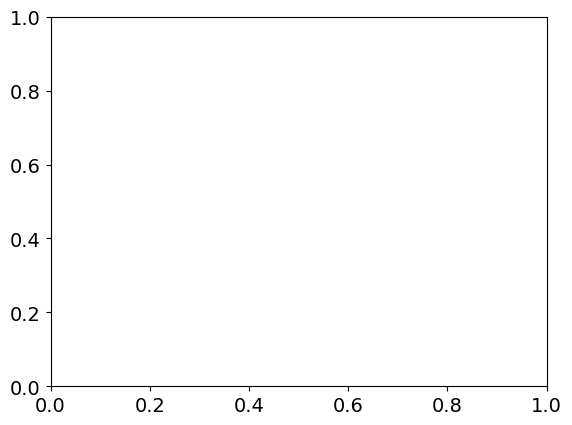

TypeError: 'NoneType' object is not subscriptable

TypeError: 'NoneType' object is not subscriptable

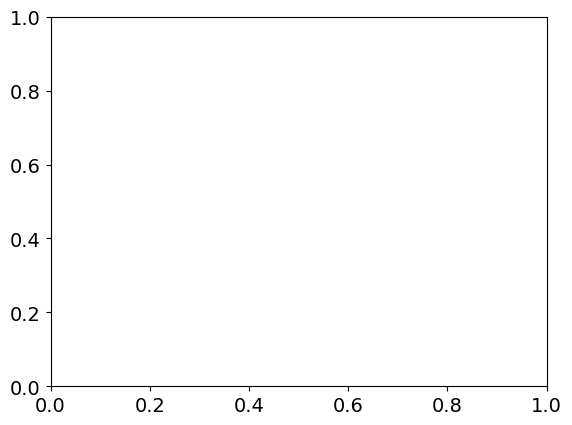

TypeError: 'NoneType' object is not subscriptable

In [36]:
# Repeat for gap*. The outcome is not expected to be consistent but it's interesting to see alternatives.
fig, ax = plt.subplots()
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestKStar = np.argmax(optimalK.gap_df['gap*'])+1
print("Best KStar", bestKStar)
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap*'], fmt='-o')
plt.ylabel('gap*')
plt.xlabel('k')
ax.text(0.65, 0.2, f'Optimal $k$ ={bestK}', transform=ax.transAxes)#, fontsize=font)
plt.savefig(f"gapstar_{varListStr}{sumStr}.svg",bbox_inches='tight')
plt.savefig(f"gapstar_{varListStr}{sumStr}.pdf",bbox_inches='tight')
# The gap statistics overestimates the number of clusters when there are many clusters.
#if bestK >=10 and bestKStar>1:
#    bestK = bestKStar

In [11]:
# Get the centroids and lables.
bestNClus = 3
Kmean = MiniBatchKMeans(n_clusters=bestNClus, random_state=randomState)
weights = weights
#Kmean.fit(clusteringData.to_numpy())
Kmean.fit(clusteringData.to_numpy(), weights)
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_
print(centroids.shape)

# This is so we can interpret the clustering result with normal scales
import pickle
pickle.HIGHEST_PROTOCOL = 4
import copy
all_mins, all_scales = pickle.load(open("minsAndScales.pkl", "rb") )
mins = dict((k, all_mins[k]) for k in trainBranches)
scales = dict((k, all_scales[k]) for k in trainBranches)
rescaledCentroids = copy.deepcopy(centroids)
for i, branch in enumerate(trainBranches):
    rescaledCentroids[:,i] = rescaledCentroids[:,i]*scales[branch]+mins[branch]

(3, 8)


In [12]:
# The final interpretation needs to change since we no longer know the "truth" due to using actual pMSSM models. Maybe centroids pre model? Maybe t-SNE?
sampNames = allData.sampName.unique()
shortNames = {}

for sampLabel in sampNames:
    shortName = sampLabel.replace('pMSSM_MCMC', '').replace('___', '_')
    shortNames[sampLabel] = shortName
    
# Clusters that contain the highest fraction of a signal are considered the best cluster.
bestClusters = {}
bestClusFracs = {}
bestClusHist = np.zeros((bestNClus))
clusFracs = {}

for sampLabel in sorted(sampNames):
    frac = -99
    bestClus = -1
    tempClusFracs = []
    for clusI in range(bestNClus):
        sampIndex = (cDataWithName.sampName==sampLabel)
        sampClusIndex = (sampIndex) & (clusLabels==clusI)
        clusFrac = 1.*sum(sampClusIndex)/sum(sampIndex)
        tempClusFracs.append(clusFrac)
        if clusFrac > frac:
            frac = clusFrac
            bestClus = clusI
    bestClusters[shortNames[sampLabel]] = bestClus
    bestClusHist[bestClus]+=1
    bestClusFracs[shortNames[sampLabel]] = frac
    clusFracs[shortNames[sampLabel]] = tempClusFracs    

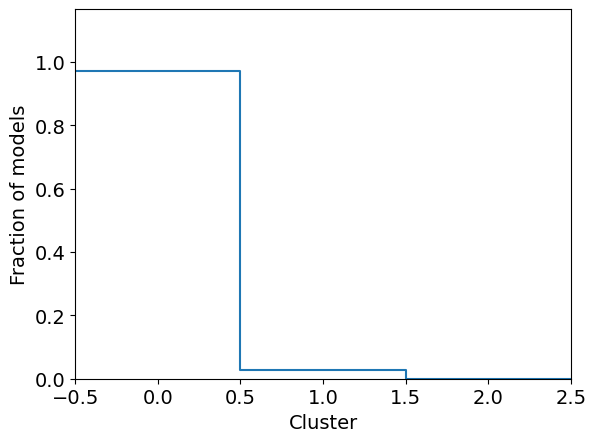

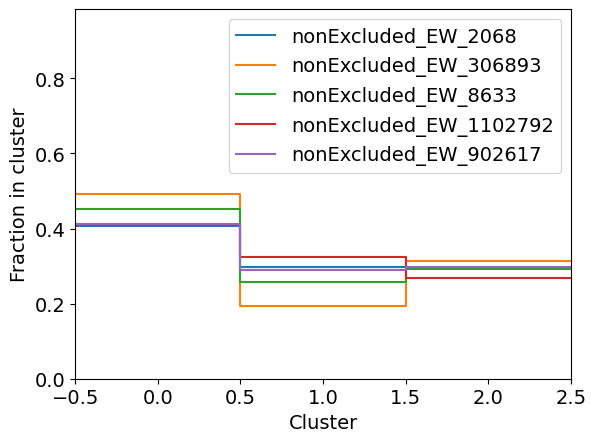

In [13]:
fig, ax = plt.subplots()
plotBestClusHist = np.append(np.insert(bestClusHist, 0, bestClusHist[0]), bestClusHist[-1])
x = np.arange(-1, bestNClus+1)
plt.step(x, plotBestClusHist/len(sampNames), where='mid')
#plt.fill_between(np.arange(bestNClus)+0.5, bestClusHist, step='pre', alpha=0.3)
ax.set_xlabel("Cluster")
ax.set_ylabel("Fraction of models")
plt.xlim([-0.5,bestNClus-0.5])
plt.ylim([0,max(plotBestClusHist/len(sampNames))*1.2])
plt.savefig(f"plots/bestClusOccupancy.svg",bbox_inches='tight')
plt.savefig(f"plots/bestClusOccupancy.pdf",bbox_inches='tight')

from numpy.random import default_rng

rng = default_rng()
indeces = rng.choice(6, size=5, replace=False)
fig, ax = plt.subplots()
maxFracs=[]
for index in indeces:
    sampLabel = sampNames[index]
    plotClusFracs = np.append(np.insert(clusFracs[shortNames[sampLabel]], 0, clusFracs[shortNames[sampLabel]][0]), clusFracs[shortNames[sampLabel]][-1])

    plt.step(x, plotClusFracs, where='mid', label=shortNames[sampLabel])
    maxFracs.append(max(clusFracs[shortNames[sampLabel]]))
    
ax.set_xlabel("Cluster")
ax.set_ylabel("Fraction in cluster")
plt.xlim([-0.5,bestNClus-0.5])
plt.ylim([0,max(maxFracs)*2])
ax.legend()
plt.savefig(f"plots/plots/clusOccupancy{sampLabel}.svg",bbox_inches='tight')
plt.savefig(f"plots/plots/clusOccupancy{sampLabel}.pdf",bbox_inches='tight')



In [14]:
errors = []
refPoints = []

if False:
    # Can't use rescaled centroids because different variables have drastically different scales (e.g., MET vs NJets)
    refPoints = centroids
    errors = np.zeros(centroids.shape)
else:
    for clusI in range(bestNClus):
        errors.append([])
        refPoints.append([])
        indivClusData = cDataWithName[clusLabels==clusI]
        tempList = []
        for varI, trainVar in enumerate(trainBranches):
            # ref = np.median(indivClusData[trainVar])
            # lowErr = ref-np.quantile(indivClusData[trainVar], 0.16)
            # highErr = np.quantile(indivClusData[trainVar], 0.84)-ref

            ref = np.mean(indivClusData[trainVar])
            lowErr = np.std(indivClusData[trainVar])
            highErr = lowErr
            refPoints[clusI].append(ref)
            tempList.append([lowErr, highErr])
        errors[clusI] = np.swapaxes(np.array(tempList), 0, 1)
    errors = np.array(errors)
    refPoints = np.array(refPoints)

2


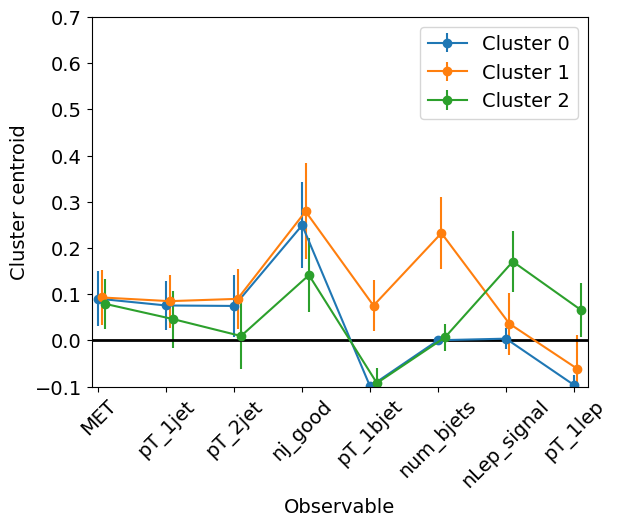

In [15]:
colors = ['r', 'g', 'b', 'y', 'c', 'k', 'm', 'tab:orange', 'tab:brown', 'olive', 'tab:purple', 'tab:pink', 'tab:blue']
markers = ["o", "^", "<", ">", "s", "D", "x", "P"]
fig, ax = plt.subplots()
bestClusIndex = sorted(list(set(bestClusters.values())))
bestClusLabels=[f'Cluster {clusI}' for clusI in bestClusIndex]
colorDict = {}

for cI in range(bestNClus):
    plt.errorbar(np.arange(len(trainBranches))+0.05*cI, refPoints[cI], yerr=errors[cI], label=f'Cluster {cI}', marker='o')#, alpha=1, s=70)

ax.set_xlabel("Observable")
ax.set_ylabel("Cluster centroid")
ax.set_xticks([i for i in range(len(trainBranches))])
ax.set_xticklabels(trainBranches, rotation=45)
plt.ylim([-0.1, 0.7])
plt.xlim([-0.1, 7.2])
ax.legend()
plt.plot([-0.1, 7.2], [0, 0], 'k-', lw=2)
plt.savefig(f"plots/obs_cms_style_postclustering_k{bestNClus}_{varListStr}{sumStr}_gap.svg",bbox_inches='tight')
plt.savefig(f"plots/obs_cms_style_postclustering_k{bestNClus}_{varListStr}{sumStr}_gap.pdf",bbox_inches='tight')

MET=166 GeV, pT_1jet=126 GeV, pT_2jet=32 GeV, nj_good=2, pT_1bjet=-85 GeV, num_bjets=0, nLep_signal=1, pT_1lep=93 GeV


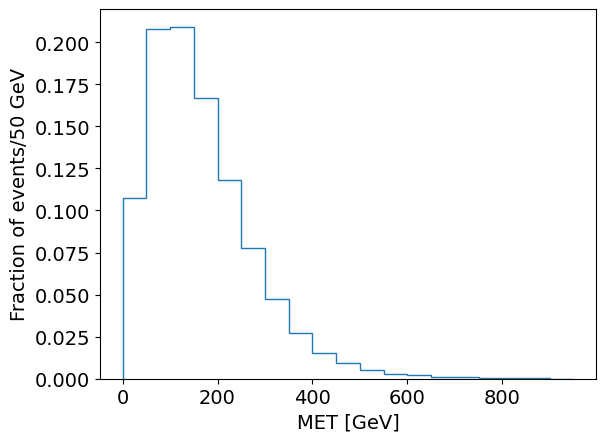

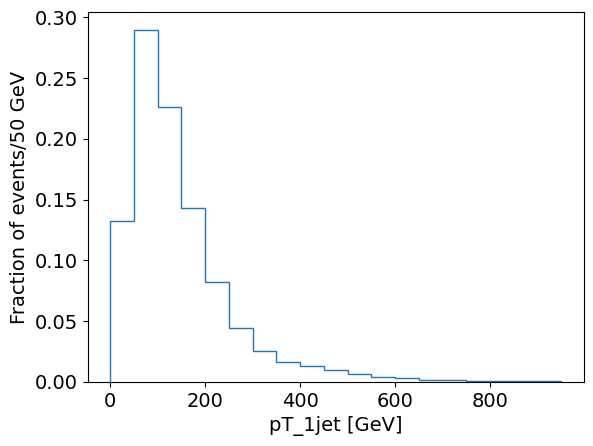

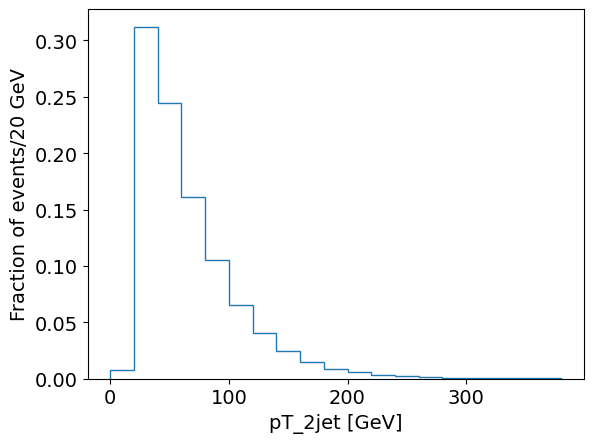

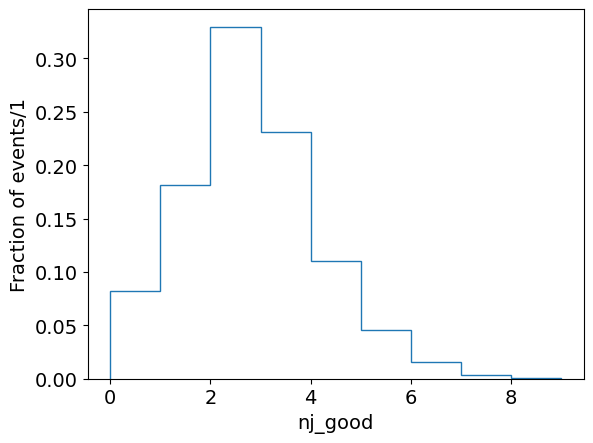

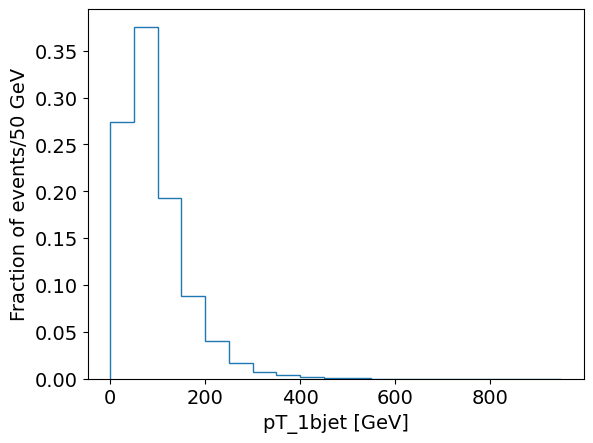

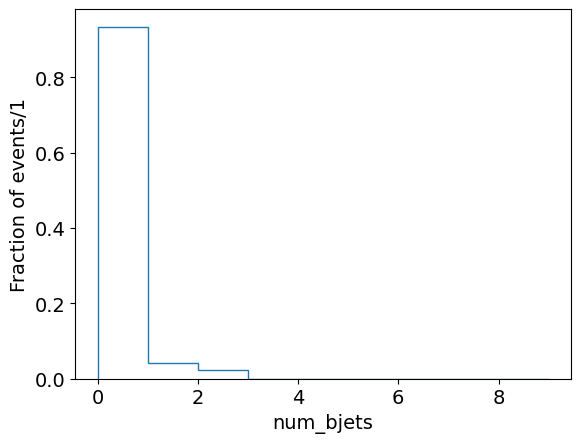

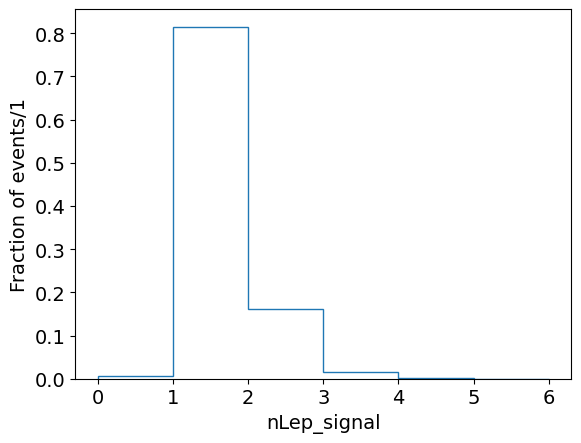

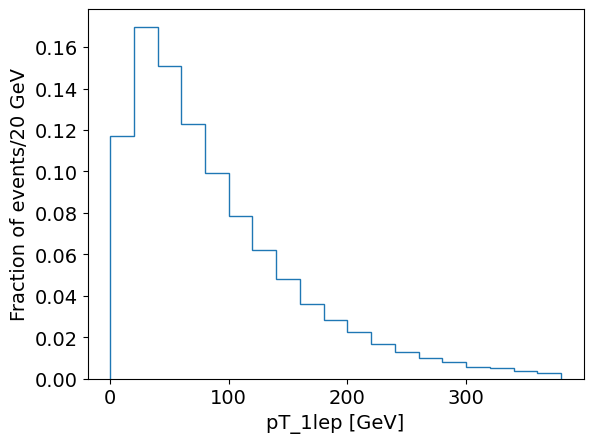

In [89]:
chosenClus = 1
indivClusData = cDataWithName[clusLabels==chosenClus]
rescaledClusData = copy.deepcopy(indivClusData[trainBranches])
bins = {'MET':[i*50 for i in range(20)],
        'HT':[i*100 for i in range(20)],
        'pT_1jet':[i*50 for i in range(20)],
        'pT_1bjet':[i*50 for i in range(20)],
        'pT_2jet':[i*20 for i in range(20)],
        'pT_3jet':[i*20 for i in range(10)],
        'pT_1lep':[i*20 for i in range(20)],
        'nj_good':[i for i in range(10)],
        'num_bjets':[i for i in range(10)],
        'nLep_signal':[i for i in range(7)],}
units = {branch: ' GeV' for branch in trainBranches}
units['nj_good'] = ''
units['nLep_signal'] = ''
units['num_bjets'] = ''
print(', '.join([f"{trainBranches[i]}={round(rescaledCentroids[chosenClus][i]):.0f}{units[trainBranches[i]]}" for i in range(len(rescaledCentroids[0]))]))

clusterHists = {}
for branch in trainBranches:
    rescaledClusData[branch] = rescaledClusData[branch]*scales[branch]+mins[branch]
    fig, ax = plt.subplots()
    if branch in bins:
        (counts, npBins) = np.histogram(rescaledClusData[branch], bins=bins[branch])
        normFact = 1./np.sum(counts)
        clusterHists[branch] = (counts, npBins, normFact)
        plt.hist(npBins[:-1], npBins, weights=normFact*counts, histtype='step')
    else:
        print("Skipping", branch, "due to lack of binning")
        continue
    if units[branch] != '':
        ax.set_xlabel(branch+' ['+units[branch].lstrip()+']')
    else:
        ax.set_xlabel(branch)
    ax.set_ylabel(f"Fraction of events/{int(bins[branch][1]-bins[branch][0])}{units[branch]}")
    plt.savefig(f"plots/{branch}_clus_{chosenClus}_k{bestNClus}_{varListStr}{sumStr}_gap.svg",bbox_inches='tight')
    plt.savefig(f"plots/{branch}_clus_{chosenClus}_k{bestNClus}_{varListStr}{sumStr}_gap.pdf",bbox_inches='tight')

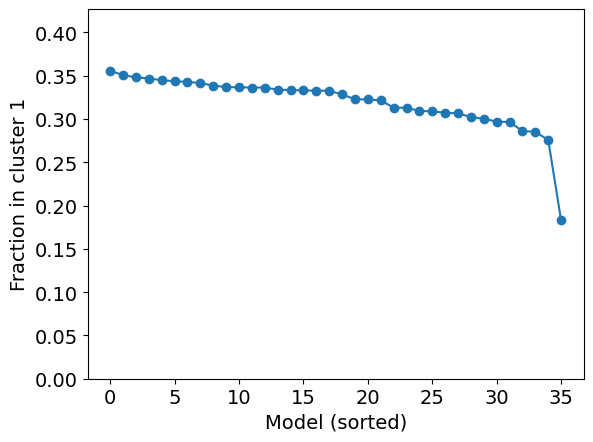

In [90]:
# Now let's figure out what models have the highest fraction of events in the interesting cluster.
interestingCluster = chosenClus
interestingClusFracs = {}
for sampLabel in sorted(sampNames):
    interestingClusFracs[shortNames[sampLabel]] = clusFracs[shortNames[sampLabel]][interestingCluster]
sortedClus = {k: v for k, v in sorted(interestingClusFracs.items(), key=lambda item: item[1], reverse=True)}
fracs = list(sortedClus.values())
fig, ax = plt.subplots()
plt.plot(np.arange(len(fracs)), fracs, marker='o')
ax.set_xlabel("Model (sorted)")
ax.set_ylabel(f"Fraction in cluster {interestingCluster}")
plt.ylim([0, fracs[0]*1.2])
plt.savefig(f"plots/clusFracs{interestingCluster}_k{bestNClus}_{varListStr}{sumStr}_gap.svg",bbox_inches='tight')
plt.savefig(f"plots/clusFracs{interestingCluster}_k{bestNClus}_{varListStr}{sumStr}_gap.pdf",bbox_inches='tight')

nonExcluded_EW_5679


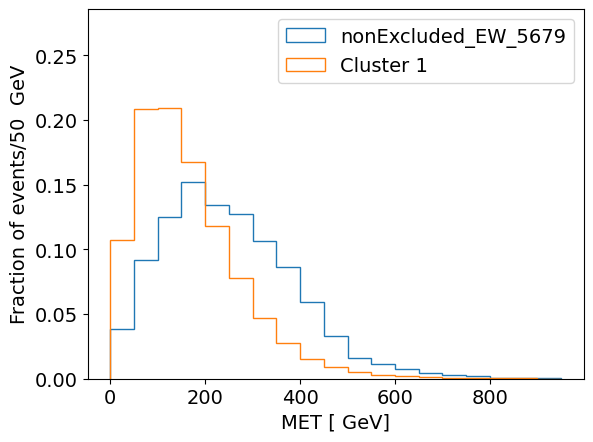

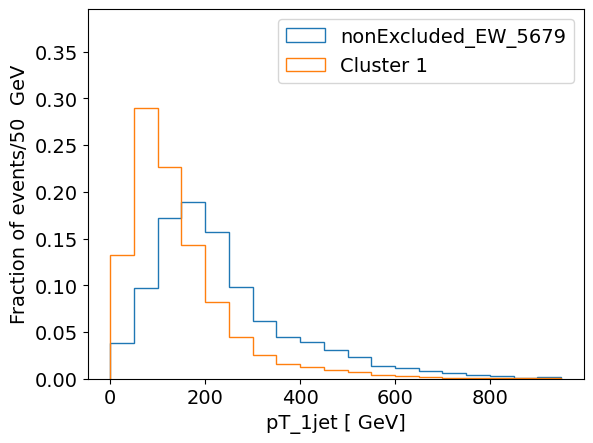

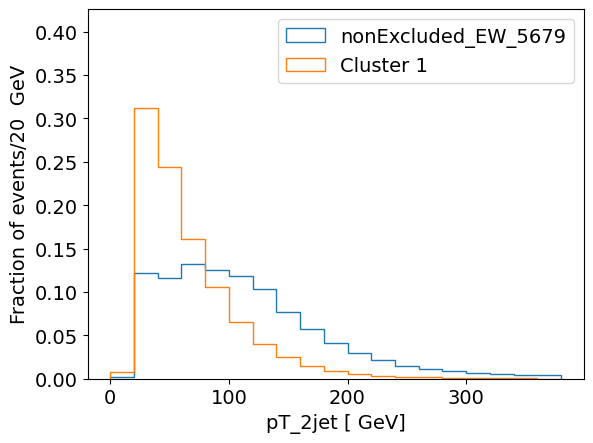

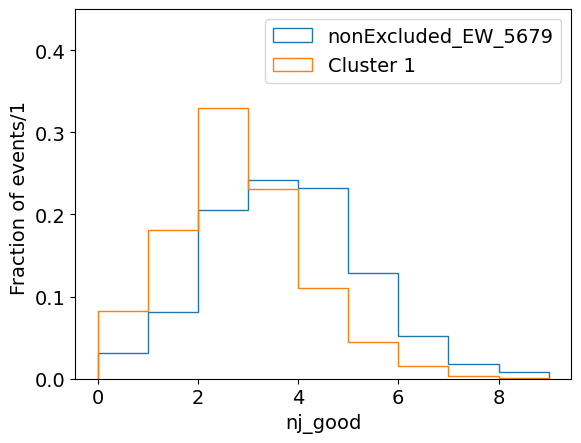

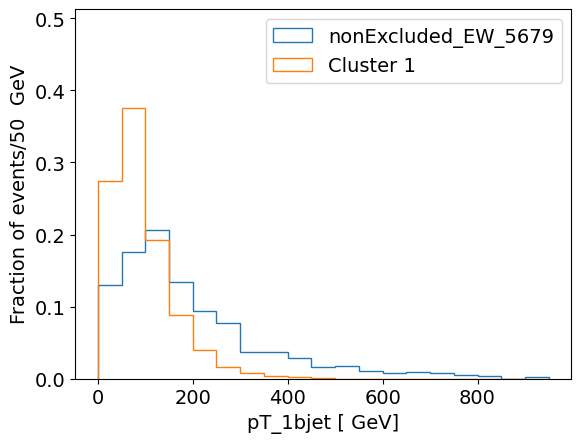

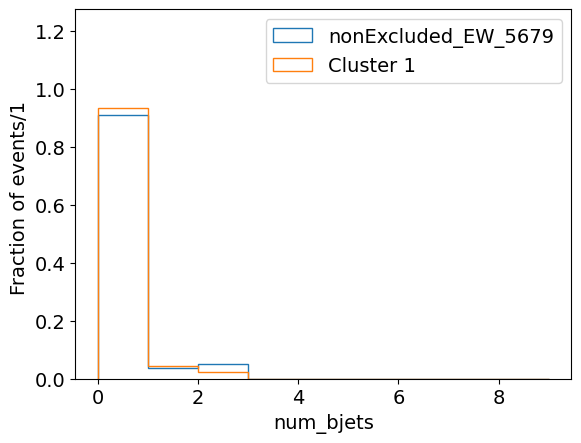

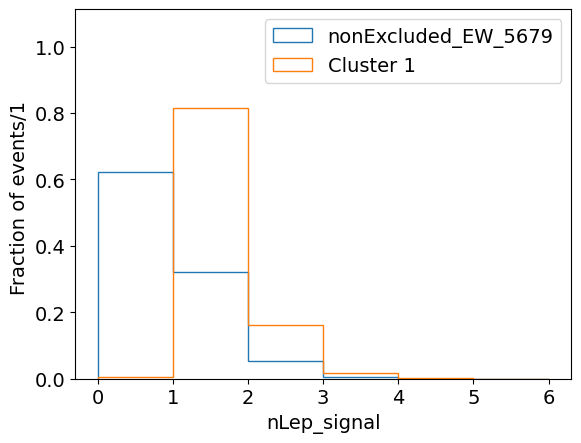

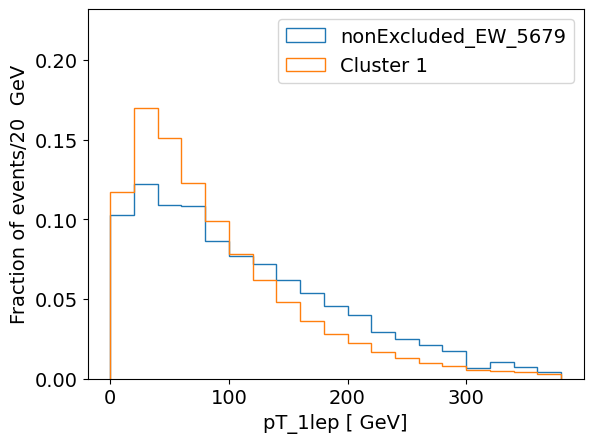

In [91]:
modelNames = sortedClus.keys()
highestFracModel = list(modelNames)[0]
print(highestFracModel)
sampIndex = (cDataWithName.sampName==highestFracModel)
modelData = cDataWithName[sampIndex]
rescaledModelData = copy.deepcopy(modelData[trainBranches])

for branch in trainBranches:
    rescaledModelData[branch] = rescaledModelData[branch]*scales[branch]+mins[branch]
    fig, ax = plt.subplots()
    if branch in bins:
        (counts, npBins) = np.histogram(rescaledModelData[branch], bins=bins[branch])
        normFact = 1./np.sum(counts)
        plt.hist(npBins[:-1], npBins, weights=normFact*counts, histtype='step', label=highestFracModel)
        plt.hist(npBins[:-1], npBins, weights=clusterHists[branch][0]*clusterHists[branch][2], histtype='step', label=f'Cluster {chosenClus}')
    else:
        print("Skipping", branch, "due to missing binning")

    if units[branch] != '':
        ax.set_xlabel(branch+' ['+units[branch]+']')
    else:
        ax.set_xlabel(branch)
    ax.set_ylabel(f"Fraction of events/{int(bins[branch][1]-bins[branch][0])} {units[branch]}")
    ax.legend()
    plt.ylim([0, ax.get_ylim()[1]*1.3])
    plt.savefig(f"plots/{branch}_model_{highestFracModel}_clus_{interestingCluster}_k{bestNClus}_{varListStr}{sumStr}_gap.svg",bbox_inches='tight')
    plt.savefig(f"plots/{branch}_model_{highestFracModel}_clus_{interestingCluster}_k{bestNClus}_{varListStr}{sumStr}_gap.pdf",bbox_inches='tight')
